In [1]:
import os, sys
sys.path.append("..")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import gc

import torch.nn.functional as F

from src.resnet2 import ResNet_D
from src.unet import UNet

from copy import deepcopy
import json

from tqdm.autonotebook import tqdm
from IPython.display import clear_output

from PIL import PngImagePlugin
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

In [2]:
!mkdir ldm_weights

mkdir: cannot create directory ‘ldm_weights’: File exists


## Main Config

In [3]:
DEVICE = 'cuda'
T_ITERS = 10
f_LR, T_LR = 1e-4, 1e-4
IMG_SIZE = 64

ZC = 1
Z_STD = 0.1

BATCH_SIZE = 11
Z_SIZE = 8

PLOT_INTERVAL = 100
COST = 'weak_mse'
CPKT_INTERVAL = 2000
MAX_STEPS = 100001


# Gamma will linearly increase from 0 to 0.66 during first 25k iters of the potential
GAMMA0, GAMMA1 = 0.0, 0.66
GAMMA_ITERS = 25000


MEAN_STD = (0.5, 0.5, 0.5)

## Prepare Samplers (X, Y)

In [7]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!cp drive/MyDrive/diploma/v1-5-pruned-emaonly.ckpt ldm_weights/v1-5-pruned-emaonly.ckpt

In [ ]:
!cp drive/MyDrive/YSDA/celeba256/archive.zip ./archive.zip
!unzip archive.zip
!cp drive/MyDrive/YSDA/anime512/dataset30000.zip ./dataset30000.zip
!unzip dataset30000.zip

In [ ]:
!pip install pytorch_lightning

In [4]:
import torch
import PIL
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CelebaDataset(Dataset):
    def __init__(self, data_root, img_size):
        self.data_root = data_root
        self.img_size = img_size
        self.image_paths = [os.path.join(data_root, file_path) for file_path in os.listdir(self.data_root)]

    def __len__(self):
        return len(self.image_paths)

    def _rescale(self, x, old_range, new_range, clamp=False):
        old_min, old_max = old_range
        new_min, new_max = new_range
        x -= old_min
        x *= (new_max - new_min) / (old_max - old_min)
        x += new_min
        if clamp:
            x = x.clamp(new_min, new_max)
        return x

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        # image = image.convert("RGB") if not image.mode == "RGB" else image

        img = torch.tensor(np.array(image.resize((self.img_size, self.img_size))), dtype=torch.float32)
        img = self._rescale(img, (0, 255), (-1, 1))
        img = img.permute(2, 0, 1)
        noise = torch.randn(4, 64, 64)
        return img, noise


dataset = CelebaDataset('celeba_hq_256', 512)
source_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [5]:
class AnimeDataset(Dataset):
    def __init__(self, data_root, img_size):
        self.data_root = data_root
        self.img_size = img_size
        self.image_paths = [os.path.join(data_root, file_path) for file_path in os.listdir(self.data_root)]

    def __len__(self):
        return len(self.image_paths)

    def _rescale(self, x, old_range, new_range, clamp=False):
        old_min, old_max = old_range
        new_min, new_max = new_range
        x -= old_min
        x *= (new_max - new_min) / (old_max - old_min)
        x += new_min
        if clamp:
            x = x.clamp(new_min, new_max)
        return x

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        # image = image.convert("RGB") if not image.mode == "RGB" else image

        img = torch.tensor(np.array(image.resize((self.img_size, self.img_size))), dtype=torch.float32)
        img = self._rescale(img, (0, 255), (-1, 1))
        img = img.permute(2, 0, 1)
        noise = torch.randn(4, 64, 64)
        return img, noise


dataset = AnimeDataset('portraits', 512)
target_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
# target_loader = None

In [6]:
iter_source, iter_target = iter(source_loader), iter(target_loader)
# iter_source, iter_target = None, None

def X_sampler():
    global iter_source, source_loader
    try:
        return next(iter_source)
        # return (torch.randn(BATCH_SIZE, 3, 64, 64), 10)
    except StopIteration:
        iter_source = iter(source_loader)
        return next(iter_source)

def Y_sampler():
    global iter_target, target_loader
    try:
        return next(iter_target)
        # return (torch.randn(BATCH_SIZE, 3, 64, 64), 10)
    except StopIteration:
        iter_target = iter(target_loader)
        return next(iter_target)

# Initializing Networks

In [7]:
def freeze(model):
    for p in model.parameters():
        p.requires_grad_(False)
    model.eval()

def unfreeze(model):
    for p in model.parameters():
        p.requires_grad_(True)
    model.train(True)

In [83]:
f = ResNet_D(IMG_SIZE, nc=4).to(DEVICE)
# f.apply(weights_init_D)

T = UNet(4+ZC, 4, base_factor=48).to(DEVICE)#.cuda() # ZC - noise input channels z

print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 9716740
f params: 22934017


In [9]:
from src.model_loader import load_models_from_standard_weights

models = load_models_from_standard_weights('ldm_weights/v1-5-pruned-emaonly.ckpt', DEVICE)

print('encoder params:', sum([param.numel()for param in models['encoder'].parameters()]))
print('decoder params:', sum([param.numel()for param in models['decoder'].parameters()]))

freeze(models['encoder'])
freeze(models['decoder'])

encoder params: 34163664
decoder params: 49490199


In [10]:
import gc
gc.collect()
torch.cuda.empty_cache()
!nvidia-smi

Sun Dec 24 23:09:16 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0              35W /  70W |    677MiB / 15360MiB |     73%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [70]:
from matplotlib import pyplot as plt

def rescale(x, old_range, new_range, clamp=False):
    old_min, old_max = old_range
    new_min, new_max = new_range
    x -= old_min
    x *= (new_max - new_min) / (old_max - old_min)
    x += new_min
    if clamp:
        x = x.clamp(new_min, new_max)
    return x

def plot_original(batch):
    fig, axes = plt.subplots(1, 5, figsize=(10, 1), dpi=100)
    batch = rescale(batch.clone(), (-1, 1), (0, 255), clamp=True)
    batch = batch.to("cpu", torch.uint8)
    for i in range(5):
        axes[i].imshow(batch[i].permute(1,2,0))
        axes[i].set_xticks([]); axes[i].set_yticks([])
    fig.tight_layout(pad=0.1)

In [71]:
X = X_sampler()

with torch.no_grad():
    X_latent = models['encoder'](X[0].to(DEVICE), X[1].to(DEVICE)).detach().cpu()

gc.collect()
torch.cuda.empty_cache()

with torch.no_grad():
    X_test_fixed = models['decoder'](X_latent.to(DEVICE)).detach().cpu()
gc.collect()
torch.cuda.empty_cache()

In [72]:
Y = Y_sampler()

with torch.no_grad():
    Y_latent = models['encoder'](Y[0].to(DEVICE), Y[1].to(DEVICE)).detach().cpu()

gc.collect()
torch.cuda.empty_cache()

with torch.no_grad():
    Y_test_fixed = models['decoder'](Y_latent.to(DEVICE)).detach().cpu()
gc.collect()
torch.cuda.empty_cache()

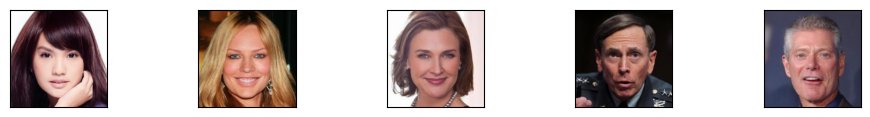

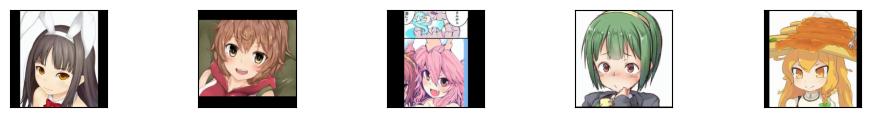

In [73]:
plot_original(X_test_fixed)
plot_original(Y_test_fixed)

In [74]:
with torch.no_grad():
    Z_test_fixed = torch.randn(BATCH_SIZE, 4, ZC, IMG_SIZE, IMG_SIZE, device='cpu') * Z_STD
    XZ_test_fixed = torch.cat([X_latent[:,None].repeat(1,4,1,1,1), Z_test_fixed], dim=2)
X_latent.shape, Z_test_fixed.shape, XZ_test_fixed.shape

(torch.Size([11, 4, 64, 64]),
 torch.Size([11, 4, 1, 64, 64]),
 torch.Size([11, 4, 5, 64, 64]))

### Plots Test

<ipython-input-75-beeee0355688>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(XZ_test_fixed, device=DEVICE).flatten(start_dim=0, end_dim=1)


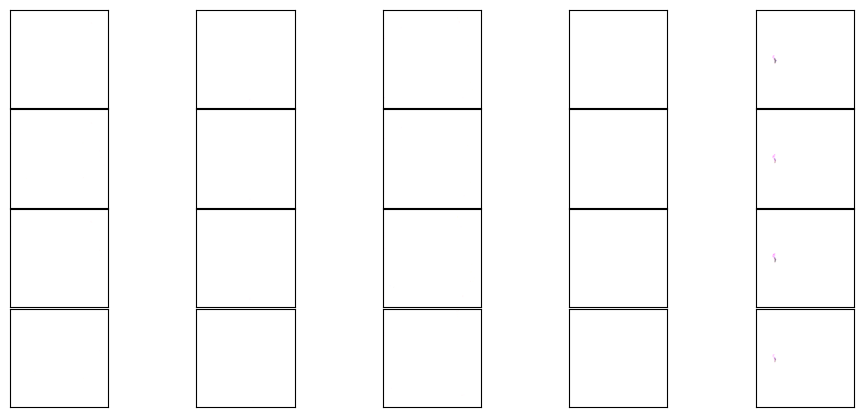

In [75]:
def plot_many_images(multibatch):
    fig, axes = plt.subplots(4, 5, figsize=(10, 4), dpi=100)
    for i in range(5):
        with torch.no_grad():
            decoded_batch = models['decoder'](multibatch[i].to(DEVICE)).detach().cpu()
        gc.collect()
        torch.cuda.empty_cache()

        decoded_batch = rescale(decoded_batch, (-1, 1), (0, 255), clamp=True)
        decoded_batch = decoded_batch.to("cpu", torch.uint8)

        for j in range(4):
            axes[j, i].imshow(decoded_batch[j].mul(0.5).add(0.5).clip(0,1).permute((1,2,0)))
            axes[j, i].set_xticks([]); axes[j, i].set_yticks([])
    fig.tight_layout(pad=0.1)

with torch.no_grad():
    T_XZ_test_fixed = T(
        torch.tensor(XZ_test_fixed, device=DEVICE).flatten(start_dim=0, end_dim=1)
    ).permute(1,2,3,0).reshape(4,64,64,BATCH_SIZE,4).permute(3,4,0,1,2).detach().to('cpu')
plot_many_images(T_XZ_test_fixed)

In [81]:
T_XZ_test_fixed.shape

torch.Size([11, 4, 4, 64, 64])

In [82]:
T_XZ_test_fixed.flatten(start_dim=0, end_dim=1).shape

torch.Size([44, 4, 64, 64])

In [76]:
!nvidia-smi

Sun Dec 24 23:44:52 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              47W /  70W |    823MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Run Training

In [77]:
T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=f_LR, weight_decay=1e-10)

<ipython-input-92-67a213c94ba1>:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(XZ_test_fixed, device=DEVICE).flatten(start_dim=0, end_dim=1)


Source images X, mapped images T(X, Z), unpaired target images Y


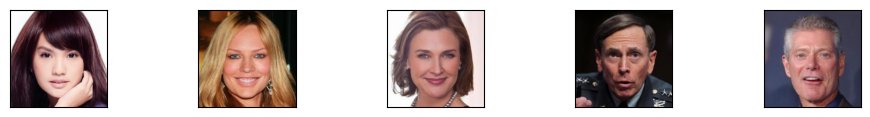

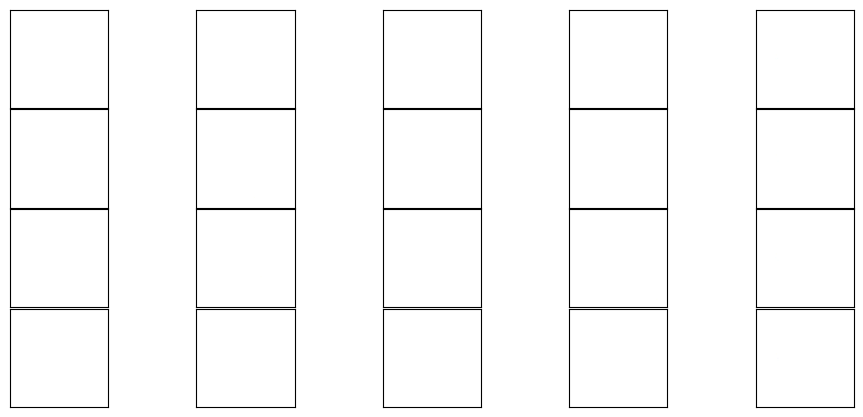

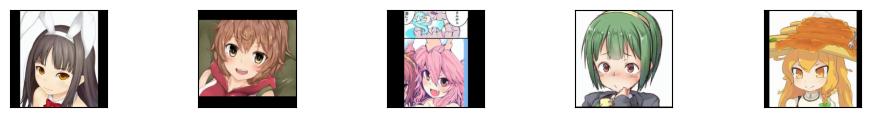

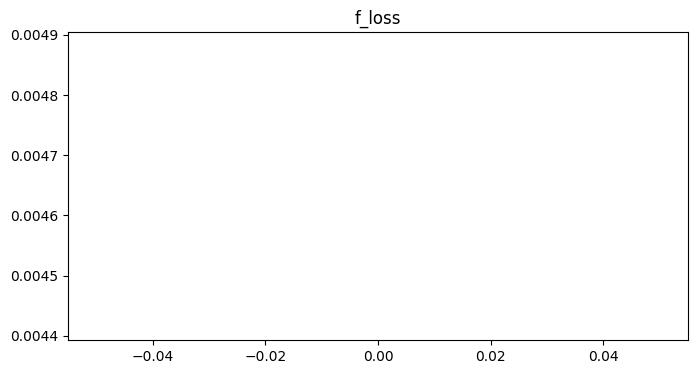

In [ ]:
def plot_f_loss(f_loss_arr):
    plt.figure(figsize = (8, 4))
    plt.title('f_loss')
    plt.plot(f_loss_arr)


f_loss_history = []
for step in tqdm(range(MAX_STEPS)):
    gamma = min(GAMMA1, GAMMA0 + (GAMMA1-GAMMA0) * step / GAMMA_ITERS)
    # T optimization
    unfreeze(T); freeze(f)
    for t_iter in range(T_ITERS):
        T_opt.zero_grad()

        X = X_sampler()
        with torch.no_grad():
            X_latent = models['encoder'](X[0].to(DEVICE), X[1].to(DEVICE)).detach().cpu()
        gc.collect()
        torch.cuda.empty_cache()

        X = X_latent[:,None].repeat(1,Z_SIZE,1,1,1).to(DEVICE)
        with torch.no_grad():
            Z = torch.randn(BATCH_SIZE, Z_SIZE, ZC, IMG_SIZE, IMG_SIZE, device=DEVICE) * Z_STD
            XZ = torch.cat([X, Z], dim=2)
        T_XZ = T(
            XZ.flatten(start_dim=0, end_dim=1)
        ).permute(1,2,3,0).reshape(4, IMG_SIZE, IMG_SIZE, BATCH_SIZE, Z_SIZE).permute(3,4,0,1,2)

        T_loss = F.mse_loss(X[:,0], T_XZ.mean(dim=1)).mean() - f(T_XZ.flatten(start_dim=0, end_dim=1)).mean() + T_XZ.var(dim=1).mean() * (1 - gamma - 1. / Z_SIZE)

        T_loss.backward(); T_opt.step()
    del T_loss, T_XZ, X, Z; gc.collect(); torch.cuda.empty_cache()

    # f optimization
    freeze(T); unfreeze(f)

    X = X_sampler()
    with torch.no_grad():
        X_latent = models['encoder'](X[0].to(DEVICE), X[1].to(DEVICE)).detach().cpu()
    gc.collect()
    torch.cuda.empty_cache()
    X = X_latent.to(DEVICE)

    with torch.no_grad():
        Z = torch.randn(BATCH_SIZE, ZC, X.size(2), X.size(3), device=DEVICE) * Z_STD
        XZ = torch.cat([X,Z], dim=1)
        T_XZ = T(XZ)


    Y = Y_sampler()
    with torch.no_grad():
        Y_latent = models['encoder'](Y[0].to(DEVICE), Y[1].to(DEVICE)).detach().cpu()
    gc.collect()
    torch.cuda.empty_cache()
    Y = Y_latent.to(DEVICE)


    f_opt.zero_grad()
    f_loss = f(T_XZ).mean() - f(Y).mean()
    f_loss.backward(); f_opt.step();
    f_loss_history.append(f_loss.detach().cpu().numpy())

    if step % PLOT_INTERVAL == 0:
        clear_output(wait=True)
        with torch.no_grad():
            T_XZ_test_fixed = T(
                torch.tensor(XZ_test_fixed, device=DEVICE).flatten(start_dim=0, end_dim=1)
            ).permute(1,2,3,0).reshape(4,64,64,BATCH_SIZE,4).permute(3,4,0,1,2).detach().to('cpu')

        print('Source images X, mapped images T(X, Z), unpaired target images Y')
        plot_original(X_test_fixed)
        plot_many_images(T_XZ_test_fixed)
        plot_original(Y_test_fixed)
        plot_f_loss(f_loss_history)
        plt.show()


#         torch.save(T.state_dict(), os.path.join(OUTPUT_PATH, f'T_{SEED}_{step}.pt'))
#         torch.save(f.state_dict(), os.path.join(OUTPUT_PATH, f'f_{SEED}_{step}.pt'))
#         torch.save(f_opt.state_dict(), os.path.join(OUTPUT_PATH, f'f_opt_{SEED}_{step}.pt'))
#         torch.save(T_opt.state_dict(), os.path.join(OUTPUT_PATH, f'T_opt_{SEED}_{step}.pt'))


In [91]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
print(10)